In [1]:
%load_ext autoreload
%autoreload 2

In [318]:
from tests.leandro.hierarchical_clustering_analysis import *
from tests.leandro.hierarchical_clustering import *
from tests.leandro.tools import get_real_data, get_one_worm_data
import itertools

In [50]:
# Real data
dataset = get_real_data('/home/lrvnc/Projects/worm-graph/conf/dataset.yaml')
oneWorm, calcium_data, time_vector = get_one_worm_data(dataset)


config:
	 dataset:
  name: Flavell2023


Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Worm ID: worm36


# Clustering the data
---

To initiate a hierarchical cluster analysis, we can invoke the function `hierarchical_clustering_analysis`, providing the dataset specific to one worm and specifying the desired number of clusters as parameters.

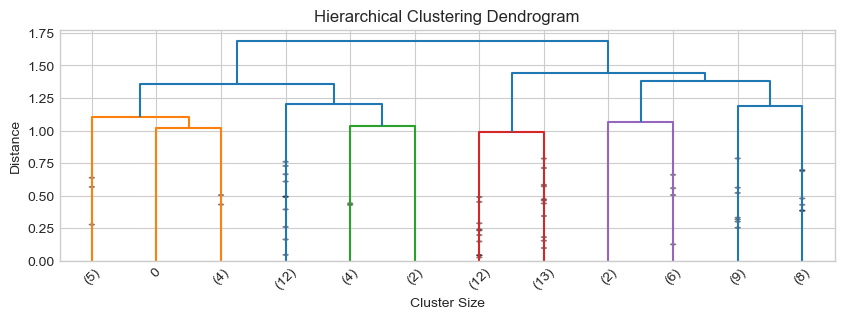

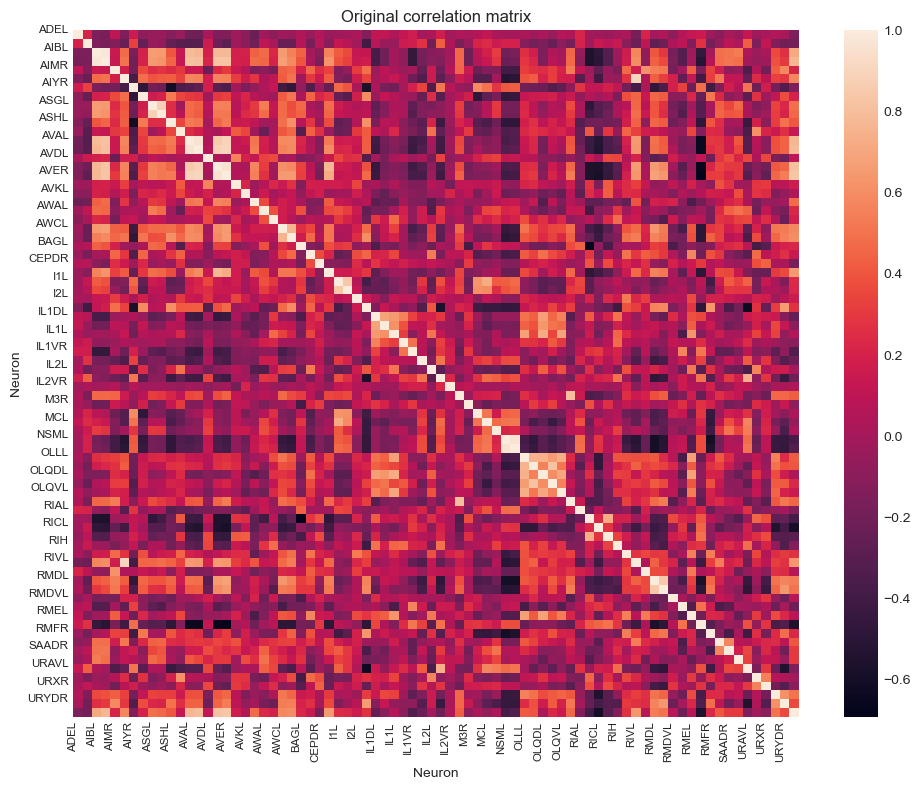

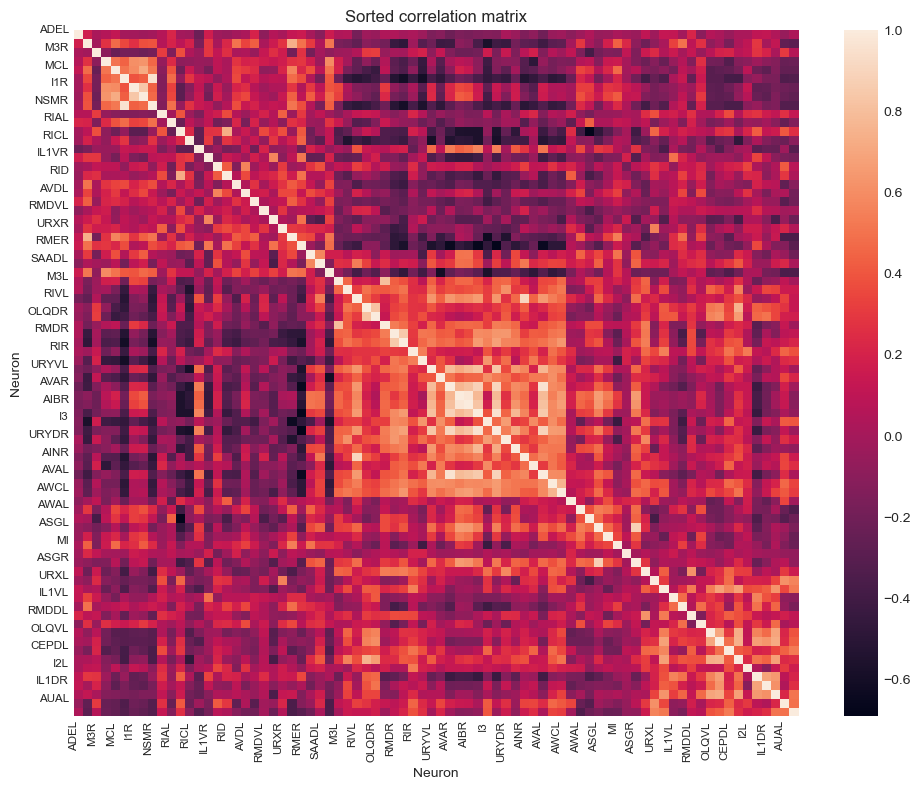

In [366]:
clusters = hierarchical_clustering_analysis(oneWorm, criterion_value=4, show_plots=True)

The function returns a single dataframe containing the neuron name as index, their computed cluster labels and the corresponding classification that can be found in the literature.

> *S* stands for *Sensory*, *M* for *Motor*, *I* for *Interneuron* and *P* for *Polymodal*

In [367]:
clusters.head()

,Computed Cluster,Reference
Neuron,,
ADEL,1,S
IL2VL,1,S
M3R,1,SM
M4,1,M
MCL,1,SM


The computed clusters can vary based on the chosen criterion, metric, and method. Here are the options available for exploration:

* Method:
    - 'single': Uses the minimum distance between observations in different clusters.
    - 'complete': Uses the maximum distance between observations in different clusters.
    - 'average': Uses the average distance between observations in different clusters.
    - 'weighted': Uses the weighted distance between observations in different clusters.
    - 'centroid': Uses the distance between centroids of clusters.
    - 'median': Uses the distance between medians of clusters.
    - 'ward': Minimizes the variance when merging clusters. ([More details](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html))

* Metric:
    - Various distance metrics can be used to compute the pairwise distances between observations. Some common options include Euclidean distance, Manhattan distance, and correlation distance. The complete list of possibilities can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist).

* Criterion:
    - 'inconsistent': Provides statistics on the inconsistency of clusters.
    - 'distance': Forms flat clusters based on a specified distance threshold.
    - 'maxclust': Forms flat clusters by specifying the desired number of clusters.
    - 'monocrit': Forms flat clusters based on a specific monocriterion.
    - 'maxclust_monocrit': Forms flat clusters based on a monocriterion with a specified number of clusters. ([More details](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster))

# Analysis tools
---

To begin the analysis, let's examine the distribution of neurons according to the literature. Since different neural datasets may have different neuron subsamples, we can group the neurons in three different ways:

> 1. Using the classification from the literature directly: Neurons are classified into the following categories: Sensory (S), Motor (M), Interneuron (I), Sensory-Interneuron (SI), Motor-Interneuron (MI), Sensory-Motor (SM), and Sensory-Motor-Interneuron (SMI).
>
> 2. Grouping the neurons into four classes: Neurons are grouped into the following categories: Sensory (S), Motor (M), Interneuron (I), and Polymodal (P).
>
> 3. Grouping the neurons into three classes: Neurons are grouped into the following categories: Sensory (S), Motor (M), and Interneuron (I).

For the third grouping method, we assume that during the period when the neural data was collected, polymodal neurons had a single function. We randomly assign the function of polymodal neurons to one of the three classes (S, M, or I), with equal probability for each class.

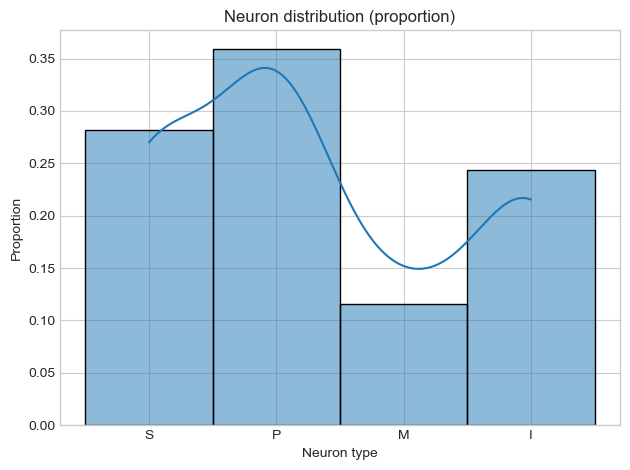

In [368]:
# stat = 'percent', 'count', 'proportion', 'density'
# group_by =  None, 'three', 'four'
grouped_clusters = neuron_distribution(clusters, stat='proportion', group_by='four')

Continuing the analysis, we can count the occurrences of each neuron type inside each computed cluster to gain insights into their respective roles. You have the option to choose whether to view the results as percentages or absolute counts.

In [369]:
# stat = 'count' or 'percent'
# dimension = 'reference' or 'computed-cluster'
count_df = count_inside_clusters(grouped_clusters, stat='count', dimension='reference')
count_df

Reference,I,M,P,S,total
Computed Cluster,,,,,
1,6,4,13,5,28
2,9,3,5,8,25
3,1,0,2,5,8
4,3,2,8,4,17
total,19,9,28,22,78


To further assist in analyzing the computed clusters, you can utilize the suggestion function, which provides recommendations regarding the role of a given cluster. The function offers two suggestions:

> 1. The first suggestion highlights the neuron type with the highest proportion within a particular cluster. This suggestion helps identify the predominant neuron type  within the cluster, offering insights into its potential role.
> 
> 2. The second suggestion identifies the cluster that exhibits the highest proportion for a specific neuron type, in a given dataset. This suggestion allows you to identify clusters that are particularly enriched in a particular neuron type, providing further clues about its potential function.

In [377]:
s1, s2 = suggest_classification(grouped_clusters)
s1, s2

({1: 'P', 2: 'I', 3: 'S', 4: 'P'}, {1: 'MP', 2: 'IS', 3: nan, 4: nan})

# Consistency across datasets
---

In [286]:
def cluster2suggestion(value, suggestion):
    return suggestion[value]

In [365]:
methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
metrics = ['euclidean', 'minkowski', 'cityblock', 'seuclidean', 'sqeuclidean', 'cosine', 'correlation',\
            'hamming', 'jaccard', 'jensenshannon', 'chebyshev', 'canberra', 'braycurtis', 'mahalanobis',\
            'yule', 'matching', 'dice', 'kulczynski1', 'rogerstanimoto', 'russellrao', 'sokalmichener',\
            'sokalsneath', 'kulczynski1']

possible_clustering_parameters = list(itertools.product(methods, metrics))

In [303]:
num_computed_clusters = 4

group_by = 'four'

if group_by == 'four':
    groups = 4
elif group_by == 'three':
    groups = 3
else:
    groups = 7

stat = 'percent'

method = 'complete'
metric = 'euclidean'

num_worms = len(dataset.keys())
print(f'Number of worms: {num_worms}')

# ===

all_worm_clusters_list = []
count_inside_clusters_array = np.zeros((num_worms, num_computed_clusters, groups))

# ===

for i, wormID in enumerate(dataset.keys()):
    clusters = hierarchical_clustering_analysis(dataset[wormID],
                                    method=method, metric=metric, show_plots=False,
                                    criterion='maxclust', criterion_value=num_computed_clusters,
                                    )

    grouped_clusters = neuron_distribution(clusters, stat=stat, group_by=group_by, show_plots=False)

    suggestion = suggest_classification(grouped_clusters=grouped_clusters)

    all_worm_clusters_list.append(grouped_clusters['Computed Cluster'].apply(cluster2suggestion, suggestion=suggestion).drop(columns=['Reference']))

    #count_inside_clusters_array[i, :, :] = delete_total(count_inside_clusters(grouped_clusters, stat='count')).values

Number of worms: 50


In [299]:
file_path = '/home/lrvnc/Projects/worm-graph/tests/leandro/data/neuron_clusters.json'

try:
    with open(file_path, 'r') as f:
        neuron_classification = json.load(f)
except FileNotFoundError:
    print(f"File not found at path: {file_path}")
except json.JSONDecodeError as e:
    print(f"Error while decoding JSON: {e}")

In [315]:
all_worms_clusters = pd.concat(all_worm_clusters_list, axis=1, keys=range(1, len(all_worm_clusters_list) + 1))
all_worms_clusters.columns = [f"worm{i}" for i in range(1, len(all_worm_clusters_list) + 1)]

for neuron in all_worms_clusters.index:
    all_worms_clusters.loc[neuron, 'Reference'] = ', '.join(neuron_classification[neuron])

# Define the replacements
replacements = {
    'interneuron': 'I',
    'motor': 'M',
    'sensory': 'S',
    'motor, interneuron': 'MI',
    'sensory, motor': 'SM',
    'sensory, interneuron': 'SI',
    'sensory, motor, interneuron': 'SMI',
    'polymodal': 'P'
}

# Replace the values in the 'Reference' column
all_worms_clusters['Reference'] = all_worms_clusters['Reference'].replace(replacements)

for wormID in all_worms_clusters.columns:
    if len(all_worms_clusters[wormID].unique()) == 5:
        print(wormID)

worm30
worm31
worm48


In [317]:
all_worms_clusters['worm30'].dropna()

Neuron
ASHL     M
SMBDR    I
SMDDR    P
IL2DR    S
IL2L     S
        ..
AIAR     P
URAVL    S
AIAL     S
AINR     M
AVKR     M
Name: worm30, Length: 71, dtype: object